/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_52121/2437896706.py:109: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(rs_crop)
/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_52121/2437896706.py:110: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


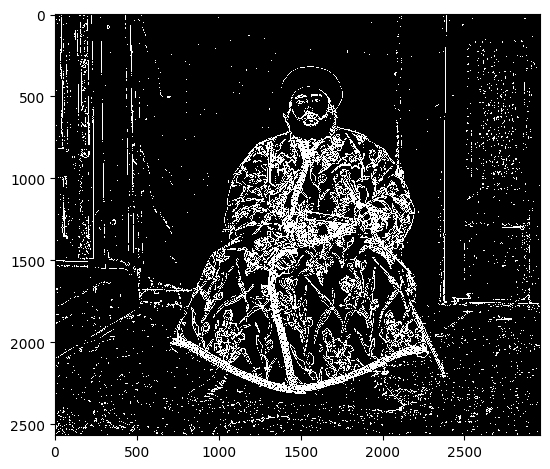

/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_52121/2437896706.py:112: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(gs_crop)
/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_52121/2437896706.py:113: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


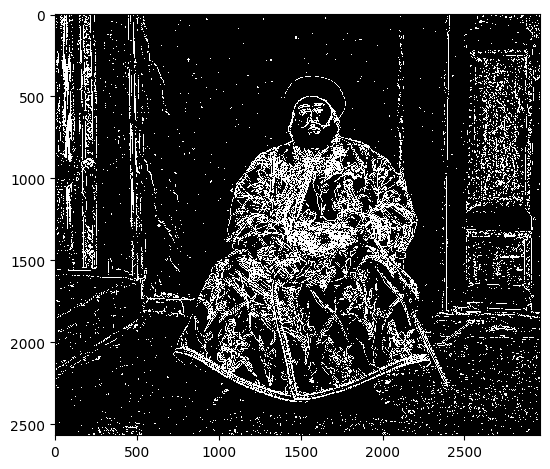

/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_52121/2437896706.py:115: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(bs_crop)
/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_52121/2437896706.py:116: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


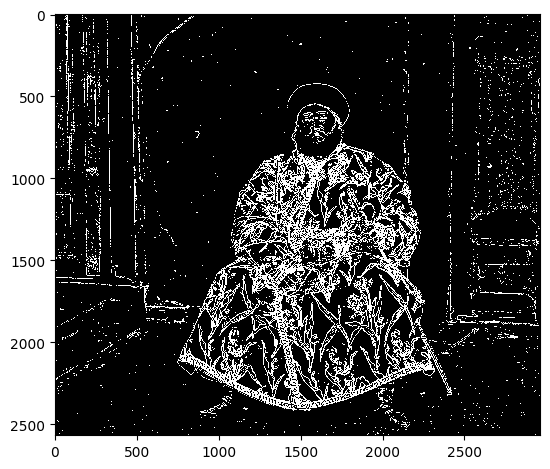

/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_52121/2437896706.py:134: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im_out)
/var/folders/yh/076cnxbj4zd6l95zlpczlgvm0000gn/T/ipykernel_52121/2437896706.py:135: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


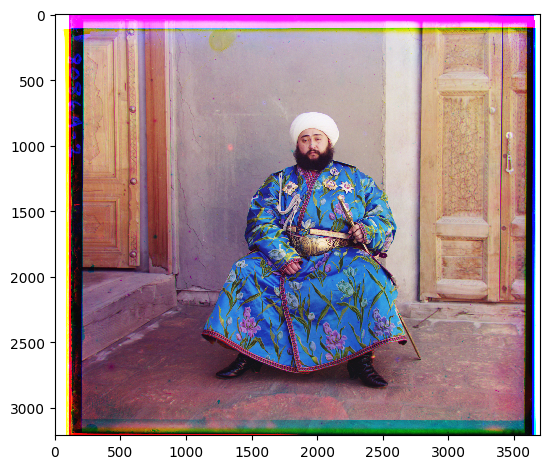

In [6]:
# CS180 (CS280A): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import cv2 as cv
import skimage as sk
import skimage.io as skio

#constants
method = 'ncc'

# L2-Norm/Euclidean Distance
def l2_norm(image1, image2):
    return np.sqrt(np.sum(np.sum((image1-image2)**2)))

# Normalized Cross Correlation
def ncc(image1, image2):
    return np.sum(image1 * image2) / (np.linalg.norm(image1) * np.linalg.norm(image2))
    
#Match image1 onto image2
def align(image1, image2, method='l2', displacement_range=15):
    cur_best_diff = None
    cur_best_disp = None
    
    #fixed range of 15 pixels   
    search_range = range(-displacement_range, displacement_range+1)

    for y in search_range:
        for x in search_range:
            rolled_image = np.roll(image1, (x,y), axis=(0,1))
            if (method == 'l2'):
                metric_result = -l2_norm(rolled_image, image2)
            if (method == 'ncc'):
                metric_result = ncc(rolled_image, image2)
    
            if cur_best_diff == None or metric_result > cur_best_diff:
                cur_best_diff = metric_result
                cur_best_disp = (x, y)
    return np.array(cur_best_disp)

# image pyramid
def pyramid(image1, image2, method='ncc', displacement_range=15, pyramid_depth=5):
    if (len(image1) < 100 or pyramid_depth == 0):
        return align(image1, image2, method, displacement_range)
    
    cur_best_disp = pyramid(sk.transform.rescale(image1, 0.5), sk.transform.rescale(image2, 0.5), method, displacement_range, pyramid_depth=pyramid_depth-1)
    cur_best_disp *=2
    scaled_shift = align(np.roll(image1, tuple(cur_best_disp), axis=(0,1)), image2, method, displacement_range)
    cur_best_disp = cur_best_disp + scaled_shift
    return cur_best_disp

def align_helper(image1, image2, method='ncc', displacement_range=15, multi_pass=True):
    if (multi_pass == True):
        return pyramid(image1, image2, method, 5) # lower displacement for pyramid
    return align(image1, image2, method, displacement_range)

# sobel edge finding
# https://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm
Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
def sobel(image):
    dx = cv.filter2D(src=image, ddepth=-1, kernel=Gx)
    dy = cv.filter2D(src=image, ddepth=-1, kernel=Gy)
    output = cv.magnitude(dx, dy)

    return threshold(output)

def crop(image, percent=.10):
    height, width = image.shape
    y_max = int(height * percent)
    x_max = int(width * percent)
    return image[y_max:-y_max, x_max:-x_max]

def threshold(image, percent=.20):
    output = np.zeros_like(image)

    thresholded_edges = image > percent
    output[thresholded_edges] = 1
    return output


# name of the input file
imname = './cs180 proj1 data/emir.tif'

# read in the image
im = skio.imread(imname)

# convert to double (might want to do this later on to save memory)
im = sk.img_as_float(im)

# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

# pre-process
r_crop = crop(r)
g_crop = crop(g)
b_crop = crop(b)
rs_crop = sobel(r_crop)
gs_crop = sobel(g_crop)
bs_crop = sobel(b_crop)

skio.imshow(rs_crop)
skio.show()

skio.imshow(gs_crop)
skio.show()

skio.imshow(bs_crop)
skio.show()



# align the images
ag_disp = align_helper(gs_crop, bs_crop, method)
ar_disp = align_helper(rs_crop, bs_crop, method)

ar = np.roll(r, ar_disp, axis=(0,1))
ag = np.roll(g, ag_disp, axis=(0,1))

im_out = np.dstack([ar, ag, b])

# save the image
fname = 'out_fname.jpg'
#skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()